# DenseNet 

마지막 인줄알았으나 final이 있었다

하지만 

이게 진짜 마지막이다. 진짜

In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 폴더 이동
%cd drive/My\ Drive/ai-school/CXR-pjt
!pwd

Mounted at /content/drive
/content/drive/My Drive/ai-school/CXR-pjt
/content/drive/My Drive/ai-school/CXR-pjt


In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np 
import cv2
import os

In [ ]:
image_size = 224
# LABELS = {'PNEUMONIA': 0, 'NORMAL': 1, 'COVID19': 2}
LABELS = {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [ ]:
# path 설정 
path_data = "./data"

path_PNEUMONIA = path_data + "/PNEUMONIA"
path_NORMAL = path_data + "/NORMAL"
path_COVID19 = path_data + "/COVID"

In [ ]:
# 이미지 파일 개수 확인
len_PNEUMONIA = len(os.listdir(path_PNEUMONIA))
len_NORMAL = len(os.listdir(path_NORMAL))
len_COVID = len(os.listdir(path_COVID19))

print(len_PNEUMONIA)
print(len_NORMAL)
print(len_COVID)

print("total: ", len_COVID + len_NORMAL + len_PNEUMONIA)

7293
8120
1344
total:  16757


# Data augmentation

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                   validation_split = 0.25)

train_generator = datagen.flow_from_directory(directory = path_data,
                                                    subset = 'training',   
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = datagen.flow_from_directory(directory = path_data,
                                                    subset = 'validation',
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

Found 12568 images belonging to 3 classes.
Found 4189 images belonging to 3 classes.


In [ ]:
def getCode(label):
    LABELS = {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
    return LABELS[label]

def getLabel(n):
    LABELS = {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
    for key, val in LABELS.items():
        if n == val:
            return key

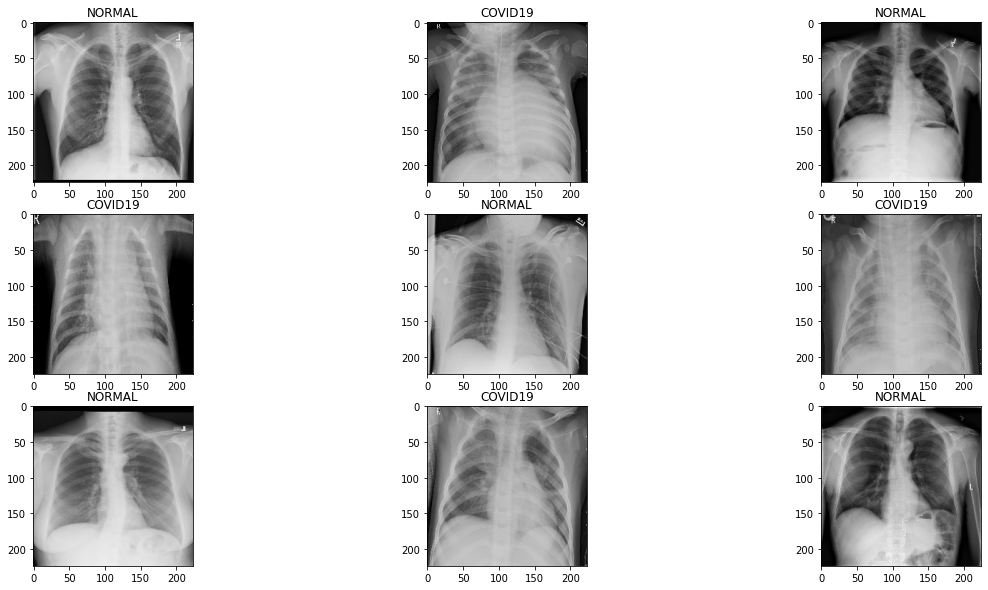

In [ ]:
# 이미지 확인
plt.figure(figsize=(20,10))
lst = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
cnt = 1
for i in lst:
    plt.subplot(3, 3, cnt)
    plt.imshow(train_generator.__getitem__(i)[0][0])
    plt.title(getLabel(np.argmax(train_generator.__getitem__(i)[1])) )
    cnt += 1
plt.show()

# DenseNet

In [ ]:
densenet = DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

densenet.trainable = False

74842112/74836368 [==============================] - 0s 0us/step


In [ ]:
# densenet.summary()

In [ ]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = densenet(image_batch)

print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

print(prediction_batch.shape)

(1, 7, 7, 1920)
(1, 1920)
(1, 3)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = densenet(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                122944    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 18,445,123
Trainable params: 123,139
Non-trainable params: 18,321,984
____________________________________

In [ ]:
len(model.trainable_variables)

4

In [17]:
initial_epochs = 20

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=valid_generator,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, verbose=1, monitor='val_loss')])

Epoch 1/10
12568/12568 [==============================] - 4710s 375ms/step - loss: 0.1526 - accuracy: 0.9503 - val_loss: 0.0687 - val_accuracy: 0.9783
Epoch 2/10
12568/12568 [==============================] - 393s 31ms/step - loss: 0.0831 - accuracy: 0.9718 - val_loss: 0.0593 - val_accuracy: 0.9807
Epoch 3/10
12568/12568 [==============================] - 388s 31ms/step - loss: 0.0666 - accuracy: 0.9784 - val_loss: 0.0542 - val_accuracy: 0.9826
Epoch 4/10
12568/12568 [==============================] - 397s 32ms/step - loss: 0.0572 - accuracy: 0.9815 - val_loss: 0.0483 - val_accuracy: 0.9840
Epoch 5/10
12568/12568 [==============================] - 387s 31ms/step - loss: 0.0512 - accuracy: 0.9821 - val_loss: 0.0549 - val_accuracy: 0.9826
Epoch 6/10
12568/12568 [==============================] - 379s 30ms/step - loss: 0.0443 - accuracy: 0.9852 - val_loss: 0.0418 - val_accuracy: 0.9854
Epoch 7/10
12568/12568 [==============================] - 378s 30ms/step - loss: 0.0405 - accuracy: 0.98

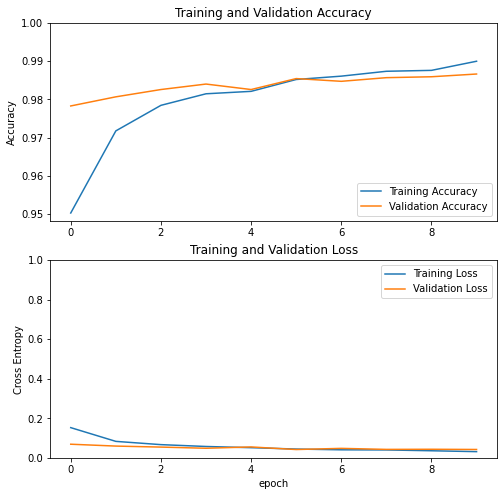

In [18]:
# 학습 곡선
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
model.evaluate(valid_generator)

4189/4189 [==============================] - 92s 22ms/step - loss: 0.0421 - accuracy: 0.9866


[0.04214637726545334, 0.9866316318511963]

## 미세조정

In [20]:
densenet.trainable = True

In [21]:
print("Number of layers in the base model: ", len(densenet.layers))

fine_tune_at = 200

for layer in densenet.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  707


In [23]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10), loss="categorical_crossentropy", metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                122944    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 18,445,123
Trainable params: 16,040,195
Non-trainable params: 2,404,928
__________________________________

In [25]:
len(model.trainable_variables)

438

In [26]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_generator,
                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, verbose=1, monitor='val_loss')])

Epoch 10/20
12568/12568 [==============================] - 782s 62ms/step - loss: 0.0980 - accuracy: 0.9680 - val_loss: 0.0465 - val_accuracy: 0.9821
Epoch 11/20
12568/12568 [==============================] - 787s 63ms/step - loss: 0.0528 - accuracy: 0.9832 - val_loss: 0.0267 - val_accuracy: 0.9921
Epoch 12/20
12568/12568 [==============================] - 793s 63ms/step - loss: 0.0413 - accuracy: 0.9878 - val_loss: 0.1624 - val_accuracy: 0.9532
Epoch 13/20
12568/12568 [==============================] - 804s 64ms/step - loss: 0.0313 - accuracy: 0.9910 - val_loss: 0.0282 - val_accuracy: 0.9924
Epoch 14/20
12568/12568 [==============================] - 831s 66ms/step - loss: 0.0282 - accuracy: 0.9928 - val_loss: 0.0263 - val_accuracy: 0.9928
Epoch 15/20
12568/12568 [==============================] - 828s 66ms/step - loss: 0.0186 - accuracy: 0.9944 - val_loss: 0.0313 - val_accuracy: 0.9959
Epoch 16/20
12568/12568 [==============================] - 838s 67ms/step - loss: 0.0209 - accuracy:

In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

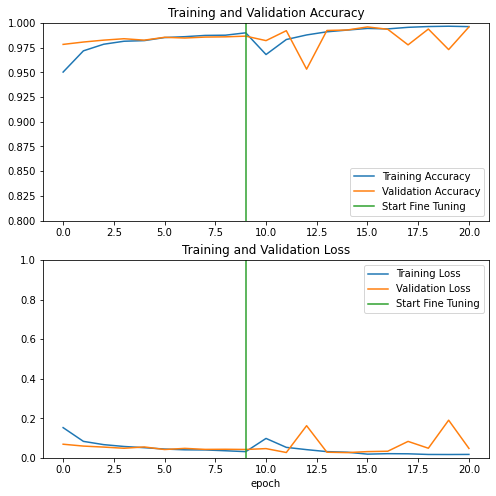

In [65]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('DenseNet_graph.jpg')
plt.show()

In [41]:
model.evaluate(valid_generator)

4189/4189 [==============================] - 93s 22ms/step - loss: 0.0332 - accuracy: 0.9926


[0.03318552300333977, 0.9925996661186218]

In [42]:
# 학습된 모델 저장하기

model.save('DenseNet.h5')

In [59]:
def getLabel(n):
    LABELS = {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
    for key, val in LABELS.items():
        if n == val:
            return key

def getCode(val):
    LABELS = {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
    return LABELS[val]

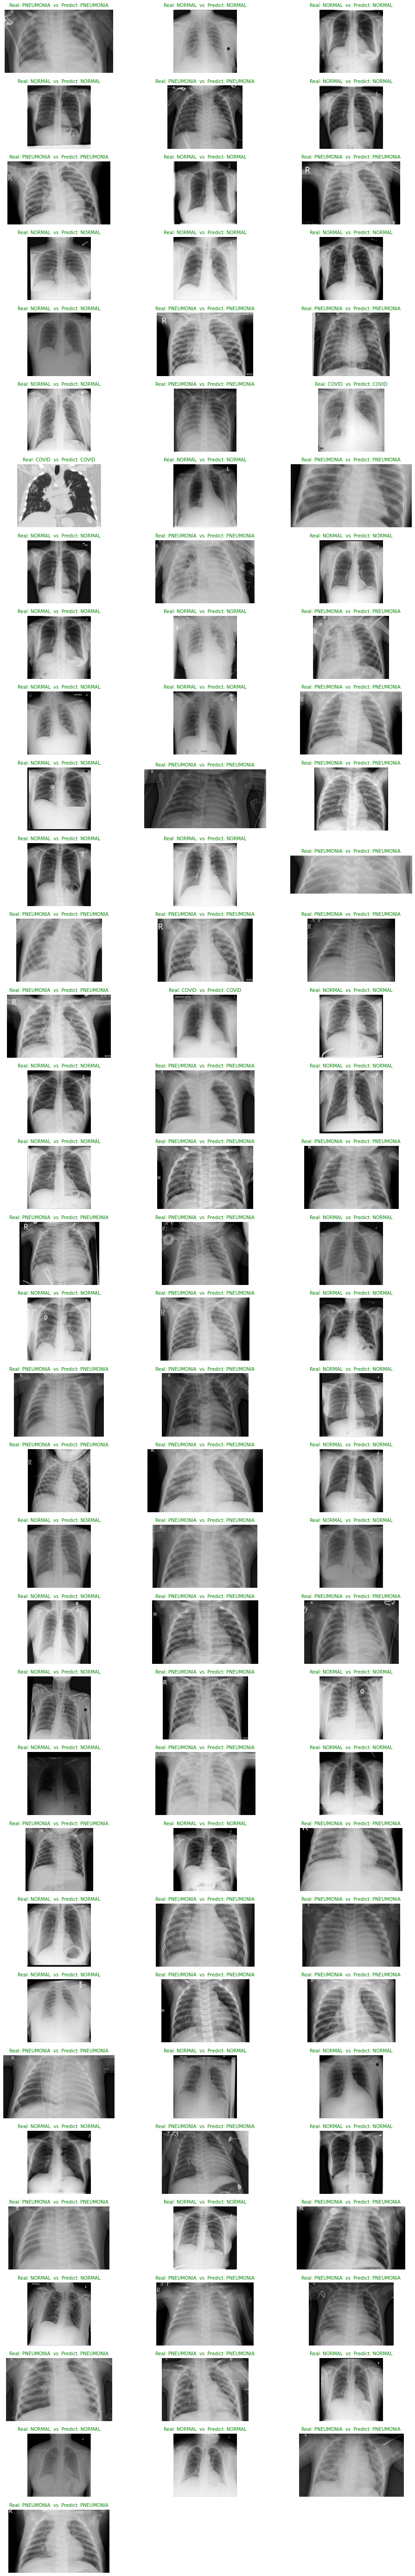

In [80]:
import random
import cv2

predictY = []
realY = []
iter = 100

plt.figure(figsize=(16,iter*3))

for i in range(iter): 
    image_path = random.choice(valid_generator.filepaths)
    plt.subplot(iter, 3, i+1)
    plt.imshow(plt.imread(image_path), cmap='gray')

    real_y = image_path.split('/')[-2]

    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224,224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    code = np.argmax(prediction)
    disease = getLabel(code)

    predictY.append(disease)
    realY.append(real_y)

    color = "green" if real_y == disease else "red"
    plt.title(f"Real: {real_y}  vs  Predict: {disease}", color=color, fontsize=10)
    plt.axis('off')

    # print(real_y, disease)
plt.show()

In [61]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [62]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predictY, realY)

print(cm)

[[ 8  1  0]
 [ 0 36  0]
 [ 0  0 55]]


Confusion matrix, without normalization
[[ 8  1  0]
 [ 0 36  0]
 [ 0  0 55]]


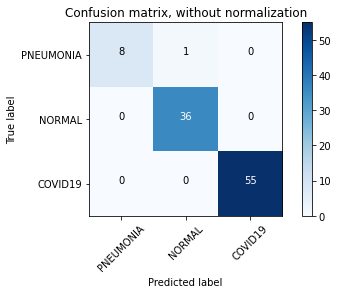

In [64]:
plt.figure()
plot_confusion_matrix(cm, classes=LABELS.keys(), title='Confusion matrix, without normalization')
plt.savefig('DenseNet_cm.jpg')

In [75]:
def getLabel(n):
    LABELS = {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
    for key, val in LABELS.items():
        if n == val:
            return key

def getCode(val):
    LABELS = {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
    return LABELS[val]


# 예측 함수
def diseasePredict(image_path):
    model_path = "Densenet.h5"
    model = tf.keras.models.load_model(model_path)

    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224,224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    code = np.argmax(prediction)
    disease = getLabel(code)

    return disease


# 예측 이미지 그리기
def showImage(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)

    disease = diseasePredict(image_path)
    plt.imshow(image, cmap='gray')
    plt.title(disease)
    plt.show()

COVID


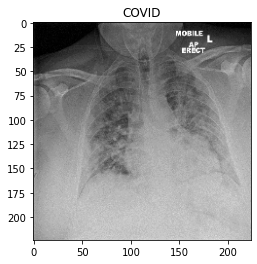

In [76]:
path = "./predict_test_img/COVID-1.jpg"

print(diseasePredict(path))

showImage(path)